# Unsupervised Learning: Clustering Lab





In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
import numpy as np
import matplotlib.pyplot as plt

## 1. (50%) Implement the k-means clustering algorithm and the HAC (Hierarchical Agglomerative Clustering) algorithm.

### 1.1.1 HAC

### Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from n to 1.  To simplify the amount of output you may want to implement a mechanism to specify for which k values actual output will be generated.


---
The output should include the following:
- The number of clusters (k).
- The total SSE of the full clustering. 


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
* The SSE of that cluster. (The sum squared error (SSE) of a single cluster is the sum of the squared euclidean distance of each cluster member to the cluster centroid.)
---
You only need to handle continuous features

In [ ]:
import copy
def single_link(distances):
  d = copy.deepcopy(distances)
  d = np.where(d==0, np.inf, d)
  return np.unravel_index(d.argmin(), d.shape)

def merge_single(link, distances):
  n = distances.shape[0]
  m = np.array([distances[link[0]], distances[link[1]]])
  m = np.min(m, axis=0)
  m = np.expand_dims(np.delete(m, link), 0)
  # Delete two rows
  distances = np.delete(distances, link, axis=0)
  # Delete two columns
  distances = np.delete(distances, link, axis=1)
  distances = np.reshape(distances, (n -2, n-2))
  # Add a column
  distances = np.c_[distances, m.T]
  m = np.expand_dims(np.append(m, 0),0)
  # Add a row
  distances = np.r_[distances, m]
  return distances

def merge_complete(link, distances):
  n = distances.shape[0]
  m = np.array([distances[link[0]], distances[link[1]]])
  m = np.max(m, axis=0)
  m = np.expand_dims(np.delete(m, link), 0)
  # Delete two rows
  distances = np.delete(distances, link, axis=0)
  # Delete two columns
  distances = np.delete(distances, link, axis=1)
  distances = np.reshape(distances, (n -2, n-2))
  # Add a column
  distances = np.c_[distances, m.T]
  m = np.expand_dims(np.append(m, 0),0)
  # Add a row
  distances = np.r_[distances, m]
  return distances

In [ ]:
class HACClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,link_type='single'): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
        self.totalSSE = 0

    def fit(self,X,y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        
        distances = np.array([np.linalg.norm(X - p, ord=2, axis=1) for p in X])

        self.keys = []
        for value in X:
          self.keys.append([value])

        self.clusters = []
        for i in distances:
          self.clusters.append(i)

        for i in range(len(distances) - self.k):
          link = single_link(distances)
          if link[0] == link[1]:
            break

          keylink0 = self.keys[link[0]]
          keylink1 = self.keys[link[1]]
          del self.keys[link[1]]
          del self.keys[link[0]]
          self.keys.append(keylink0 + keylink1)

          # Adding to clusters
          link0 = self.clusters[link[0]]
          link1 = self.clusters[link[1]]
          self.clusters.pop(link[1])
          self.clusters.pop(link[0])
          self.clusters.append(link0 + link1)

          if self.link_type == 'single':
            distances = merge_single(link, distances)
          else:
            distances = merge_complete(link, distances)


        self.clusterSizes = []
        self.SSE = []
        self.centroids = []
        for i in self.keys:
          self.clusterSizes.append(len(i))
          mean = sum(i) / len(i)
          self.centroids.append(mean)
          SSE = 0
          for j in i:
            SSE += np.linalg.norm(mean - j, ord=2)**2
          self.SSE.append(SSE)
        self.totalSSE = sum(self.SSE)
          
        
        return self
    
    def print_clusters(self):
        """
            Used for grading.
            print("{:d}\n".format(k))
            print("{:.4f}\n\n".format(total SSE))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("\n")
                print("{:d}\n".format(size of cluster))
                print("{:.4f}\n\n".format(SSE of cluster))
        """
        print("{:d}".format(self.k))
        print("{:.4f}\n".format(self.totalSSE))
        for i in range(len(self.centroids)):
            print(np.array2string(self.centroids[i],precision=4,separator=","))
            print("{:d}".format(self.clusterSizes[i]))
            print("{:.4f}\n".format(self.SSE[i]))
        pass

### 1.1.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be a lot smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points should be commented out.



- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting SSE and centroid values.


---
Solutions in files:

[Debug HAC Single.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link.txt)

[Debug HAC Complete.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link.txt)

In [ ]:
# Debug Here

from scipy.io import arff
import pandas as pd
from sklearn import preprocessing

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output abalone.arff

abalone = arff.loadarff('abalone.arff')
abalone = pd.DataFrame(abalone[0])
abalone.head()
abalone.iloc[:,:] = (abalone.iloc[:,:] - abalone.iloc[:,:].min()) / (abalone.iloc[:,:].max() - abalone.iloc[:,:].min())
abalone = np.array(abalone)

# Train on training set

hac = HACClustering(k=5, link_type='single')
hac.fit(abalone)
hac.print_clusters()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0   920k      0 --:--:-- --:--:-- --:--:--  920k
5
54.4392

[0.9189,0.9438,0.7105,0.7016,0.759 ,0.7222,0.4472,0.8824]
1
0.0000

[1.    ,0.9888,0.7895,1.    ,1.    ,0.8915,0.7186,0.5882]
1
0.0000

[0.9189,0.9888,0.8684,0.719 ,0.5797,0.7512,0.6432,0.9412]
1
0.0000

[1.    ,0.9831,0.8026,0.8343,0.6575,0.7825,0.9221,0.8824]
2
0.0475

[0.599 ,0.5923,0.4915,0.2826,0.2682,0.2921,0.2316,0.3849]
195
54.3917



### 1.1.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

In [ ]:
# Load evaluation data

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output seismic.arff

seismic = arff.loadarff('seismic.arff')
seismic = pd.DataFrame(seismic[0])
seismic['Class'] = [int(s.decode()) for s in seismic['Class']]

seismic.head()

seismic.iloc[:,:] = (seismic.iloc[:,:] - seismic.iloc[:,:].min()) / (seismic.iloc[:,:].max() - seismic.iloc[:,:].min())
seismic = np.array(seismic)

# Train on evaluation data

hac_eval = HACClustering(k=5, link_type='single')
hac_eval.fit(seismic)

# Print clusters

hac_eval.print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  32120      0 --:--:-- --:--:-- --:--:-- 32120
5
22.4548

[0.2774,0.2597,1.    ,0.1224,0.4505,0.7549,0.129 ,0.    ]
1
0.0000

[0.3065,0.3333,0.6979,0.2792,0.3787,1.    ,0.2373,0.    ]
1
0.0000

[0.0884,0.1818,0.    ,0.145 ,0.1538,0.1245,0.    ,0.    ]
1
0.0000

[0.3159,0.3648,0.5145,0.349 ,0.3338,0.3077,0.2868,0.    ]
67
10.0257

[0.714 ,0.7588,0.5603,0.7028,0.6994,0.4864,0.7393,1.    ]
70
12.4291



### 1.2.1 K-Means

### Code requirements 
- Ability to choose k and specify k initial centroids
- Use Euclidean Distance as metric
- Ability to handle distance ties
- Include output label as a cluster feature


---
The output should include the following:
- The number of clusters (k).
- The total SSE of the full clustering. 


For each cluster report include:


- The centroid id.
- The number of instances tied to that centroid. 
- The SSE of that cluster. (The sum squared error (SSE) of a single cluster is the sum of the squared euclidean distance of each cluster member to the cluster centroid.)
---
You only need to handle continuous features

In [ ]:
def assign_to_clusters(distances, x, all_clusters):
  for i, d in enumerate(distances):
    min_position = 0
    smallest = d[0]
    for j in range(1, len(d)):
      if (smallest > d[j]):
          smallest = d[j]
          min_position = j
    all_clusters[min_position].append(x[i])
  return all_clusters

In [ ]:
class KMEANSClustering(BaseEstimator,ClusterMixin):

    def __init__(self,k=3,debug=False): ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug

    def fit(self,X,y=None):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.initials = []
        random_cent = 0
        
        if self.debug == True:
          for i in range(self.k):
            initial_centroid = X[i]
            self.initials.append(initial_centroid)
        else:
          for i in range(self.k):
            random_cent = random.randint(0,len(X) - 1)
            initial_centroid = X[random_cent]
            self.initials.append(initial_centroid)
        print("Initials", self.initials)
        while(True):
          checkArray = copy.deepcopy(self.initials)
          self.all_clusters = []
          for i in range(self.k):
            one_cluster = []
            self.all_clusters.append(one_cluster)
          distances = np.array([np.linalg.norm(X - c, ord=2, axis=1) for c in self.initials]).T
          self.all_clusters = assign_to_clusters(distances, X, self.all_clusters)
          means = []
          for i in self.all_clusters:
            one_mean = np.array(i).mean(0)
            means.append(one_mean)
          self.initials = means
          stop_iteration = True
          for i in range(len(self.initials)):
            for j in range(len(self.initials[i])):
              if checkArray[i][j] != self.initials[i][j]:
                stop_iteration = False
          if stop_iteration == True:
            break


        self.clusterSizes = []
        self.SSE = []
        self.centroids = []
        for i in self.all_clusters:
          self.clusterSizes.append(len(i))
          mean = sum(i) / len(i)
          self.centroids.append(mean)
          SSE = 0
          for j in i:
            SSE += np.linalg.norm(mean - j, ord=2)**2
          self.SSE.append(SSE)
        self.totalSSE = sum(self.SSE)


        return self
    
    def print_clusters(self):
        """
            Used for grading.
            print("{:d}\n".format(k))
            print("{:.4f}\n\n".format(total SSE))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("\n")
                print("{:d}\n".format(size of cluster))
                print("{:.4f}\n\n".format(SSE of cluster))
        """
        print("{:d}".format(self.k))
        print("{:.4f}\n".format(self.totalSSE))
        for i in range(len(self.initials)):
            print(np.array2string(self.initials[i],precision=4,separator=","))
            print("{:d}".format(self.clusterSizes[i]))
            print("{:.4f}\n".format(self.SSE[i]))
        pass

### 1.2.2 Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


- Train until convergence
- Normalize Data
- K = 5
- Use the first k instances as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting SSE and centroid values


---
Solutions in files:

[Debug K Means.txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means.txt)

In [ ]:
# Load debug data
import random
import copy

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff --output abalone_k.arff

abalone_k = arff.loadarff('abalone_k.arff')
abalone_k = pd.DataFrame(abalone_k[0])
abalone_k.head()
abalone_k.iloc[:,:] = (abalone_k.iloc[:,:] - abalone_k.iloc[:,:].min()) / (abalone_k.iloc[:,:].max() - abalone_k.iloc[:,:].min())
abalone_k = np.array(abalone_k)

# Train on debug data

kmeans = KMEANSClustering(k=5, debug=True)
kmeans.fit(abalone_k)

# Print clusters

kmeans.print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  187k  100  187k    0     0  2981k      0 --:--:-- --:--:-- --:--:-- 2935k
Initials [array([0.51351351, 0.52808989, 0.28947368, 0.19206349, 0.20188679,
       0.17680075, 0.14070352, 0.64705882]), array([0.32432432, 0.30337079, 0.26315789, 0.07757937, 0.08396226,
       0.07857811, 0.06030151, 0.17647059]), array([0.64864865, 0.65168539, 0.5       , 0.25674603, 0.23207547,
       0.2525725 , 0.20100503, 0.29411765]), array([0.48648649, 0.52808989, 0.44736842, 0.19285714, 0.19339623,
       0.20112254, 0.14572864, 0.35294118]), array([0.28828829, 0.28089888, 0.21052632, 0.06944444, 0.0745283 ,
       0.06173994, 0.04522613, 0.17647059])]
5
9.7826

[0.7325,0.7327,0.627 ,0.3817,0.3633,0.4045,0.3046,0.4839]
75
4.0454

[0.3704,0.3519,0.2686,0.0926,0.0935,0.094 ,0.0792,0.218 ]
34
0.6609

[0.9035,0.905 ,0.7774,0.6579,0.5767,0.6193,0.

### 1.2.3 Evaluation

We will evaluate your model based on its print_clusters() output using [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff)

In [ ]:
# Load evaluation data

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff --output seismic.arff

seismic = arff.loadarff('seismic.arff')
seismic = pd.DataFrame(seismic[0])
seismic['Class'] = [int(s.decode()) for s in seismic['Class']]

seismic.head()

seismic.iloc[:,:] = (seismic.iloc[:,:] - seismic.iloc[:,:].min()) / (seismic.iloc[:,:].max() - seismic.iloc[:,:].min())
seismic = np.array(seismic)

kmeans_eval = KMEANSClustering(k=5, debug=True)
kmeans_eval.fit(seismic)

# Print clusters

kmeans_eval.print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  22349      0 --:--:-- --:--:-- --:--:-- 22349
Initials [array([0.40502513, 0.47835498, 0.40202276, 0.4856176 , 0.39053254,
       0.24593321, 0.34515017, 0.        ]), array([0.36683417, 0.41991342, 0.52970923, 0.3677383 , 0.40828402,
       0.04272032, 0.21516494, 0.        ]), array([0.30753769, 0.31601732, 0.83185841, 0.21940214, 0.41166526,
       0.32667782, 0.1506647 , 0.        ]), array([0.26231156, 0.28354978, 0.71175727, 0.23801466, 0.44716822,
       0.25235224, 0.14081733, 0.        ]), array([0.49346734, 0.51082251, 0.81163085, 0.42639594, 0.60185968,
       0.09964695, 0.3229936 , 0.        ])]
5
14.7279

[0.5349,0.6013,0.4617,0.5541,0.5232,0.5544,0.6248,1.    ]
22
2.0160

[0.3684,0.4338,0.4356,0.4388,0.3573,0.2988,0.3673,0.    ]
31
2.4076

[0.3658,0.3854,0.7563,0.3093,0.4659,0.3691,0

## 2.1.1 (7.5%) Clustering the Iris Classification problem - HAC

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

- Use single-link and complete link clustering algorithms
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the total SSE for each k and discuss your results (i.e. what kind of clusters are being made).
---

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0   187k      0 --:--:-- --:--:-- --:--:--  187k
Clusters:  2
2
22.6697

[0.1611,0.425 ,0.078 ,0.0333]
5
0.0093

[0.5003,0.3719,0.6015,0.5921]
109
19.8626

[0.2492,0.6447,0.1163,0.11  ]
36
2.7978

Clusters:  3
3
22.6697

[0.1611,0.425 ,0.078 ,0.0333]
5
0.0093

[0.5003,0.3719,0.6015,0.5921]
109
19.8626

[0.2492,0.6447,0.1163,0.11  ]
36
2.7978

Clusters:  4
4
20.6766

[0.1611,0.425 ,0.078 ,0.0333]
5
0.0093

[0.4028,0.25  ,0.6864,0.7708]
2
0.0049

[0.2402,0.6679,0.0828,0.0711]
34
0.7998

[0.5003,0.3719,0.6015,0.5921]
109
19.8626

Clusters:  5
5
11.1705

[0.1611,0.425 ,0.078 ,0.0333]
5
0.0093

[0.4028,0.25  ,0.6864,0.7708]
2
0.0049

[0.2402,0.6679,0.0828,0.0711]
34
0.7998

[0.5479,0.3656,0.6615,0.6543]
98
10.1986

[0.0758,0.428 ,0.0663,0.0379]
11
0.1579

Clusters:  6
6
11.0665

[0.0556,0.125 ,0.0508,0.083

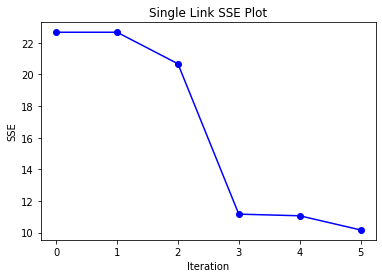

In [ ]:
# Iris Classification using single-link
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

iris = arff.loadarff('iris.arff')
iris = pd.DataFrame(iris[0])
iris['class'] = iris['class'].str.decode('utf-8')

le = preprocessing.LabelEncoder()
le.fit(iris['class'])
iris['class'] = le.transform(iris['class'])

iris.head()
iris.iloc[:,:] = (iris.iloc[:,:] - iris.iloc[:,:].min()) / (iris.iloc[:,:].max() - iris.iloc[:,:].min())
iris = np.array(iris)
iris_data = iris[:,:-1]

singleSSE = []
for i in range(2,8):
  hac_iris = HACClustering(k=i, link_type='single')
  hac_iris.fit(iris_data)
  print("Clusters: ", i)
  singleSSE.append(hac_iris.totalSSE)
  hac_iris.print_clusters()

plt.plot(singleSSE, color='blue', marker='o')
plt.ylabel('SSE')
plt.xlabel('Iteration')
plt.title("Single Link SSE Plot")
plt.show()


Clusters:  2
2
25.7462

[0.719 ,0.4645,0.8106,0.8419]
34
1.6041

[0.3436,0.4318,0.367 ,0.3452]
116
24.1422

Clusters:  3
3
7.1537

[0.719 ,0.4645,0.8106,0.8419]
34
1.6041

[0.4554,0.3112,0.5855,0.5612]
66
3.7046

[0.1961,0.5908,0.0786,0.06  ]
50
1.8450

Clusters:  4
4
6.2517

[0.1062,0.4289,0.0708,0.0343]
17
0.1991

[0.2424,0.6742,0.0827,0.0732]
33
0.7438

[0.719 ,0.4645,0.8106,0.8419]
34
1.6041

[0.4554,0.3112,0.5855,0.5612]
66
3.7046

Clusters:  5
5
4.7586

[0.1062,0.4289,0.0708,0.0343]
17
0.1991

[0.3515,0.2399,0.512 ,0.4741]
29
0.9845

[0.2424,0.6742,0.0827,0.0732]
33
0.7438

[0.5368,0.3671,0.6432,0.6295]
37
1.2271

[0.719 ,0.4645,0.8106,0.8419]
34
1.6041

Clusters:  6
6
4.1143

[0.1062,0.4289,0.0708,0.0343]
17
0.1991

[0.6365,0.4601,0.7657,0.8569]
23
0.4522

[0.3515,0.2399,0.512 ,0.4741]
29
0.9845

[0.8914,0.4735,0.9045,0.8106]
11
0.5076

[0.2424,0.6742,0.0827,0.0732]
33
0.7438

[0.5368,0.3671,0.6432,0.6295]
37
1.2271

Clusters:  7
7
3.6657

[0.5604,0.4221,0.6094,0.5779]
23
0.4665

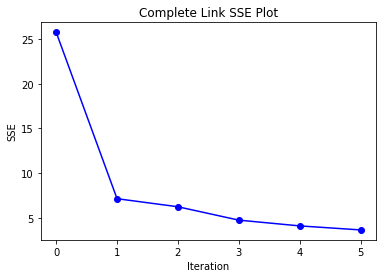

In [ ]:
# Iris Classification using complete-link
completeSSE = []
for i in range(2,8):
  hac_iris = HACClustering(k=i, link_type='complete')
  hac_iris.fit(iris_data)
  print("Clusters: ", i)
  completeSSE.append(hac_iris.totalSSE)
  hac_iris.print_clusters()

plt.plot(completeSSE, color='blue', marker='o')
plt.ylabel('SSE')
plt.xlabel('Iteration')
plt.title("Complete Link SSE Plot")
plt.show()

I chose to normalize the iris dataset.
Complete link seems to work better, judging off of the SSE outputs of both models. The single link has an SSE that starts really high, and it takes a few iterations to drop. Its' SSE is pretty low, but the complete link model's SSE gets much lower. Complete link's SSE also starts much lower, and drops quicker.

## 2.1.2 (5%) Clustering the Iris Classification problem - HAC

Requirements:
- Repeat excercise 2.1.1 and include the output label as one of the input features.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0   158k      0 --:--:-- --:--:-- --:--:--  158k
Clusters:  2
2
37.4962

[0.1611,0.425 ,0.078 ,0.0333,0.    ]
5
0.0093

[0.5033,0.3735,0.6015,0.5914,0.6667]
108
31.2176

[0.247 ,0.6329,0.1292,0.125 ,0.0811]
37
6.2693

Clusters:  3
3
37.4962

[0.1611,0.425 ,0.078 ,0.0333,0.    ]
5
0.0093

[0.5033,0.3735,0.6015,0.5914,0.6667]
108
31.2176

[0.247 ,0.6329,0.1292,0.125 ,0.0811]
37
6.2693

Clusters:  4
4
32.0830

[0.1611,0.425 ,0.078 ,0.0333,0.    ]
5
0.0093

[0.2402,0.6679,0.0828,0.0711,0.    ]
34
0.7998

[0.3241,0.2361,0.6554,0.7361,1.    ]
3
0.0562

[0.5033,0.3735,0.6015,0.5914,0.6667]
108
31.2176

Clusters:  5
5
17.1019

[0.1611,0.425 ,0.078 ,0.0333,0.    ]
5
0.0093

[0.2402,0.6679,0.0828,0.0711,0.    ]
34
0.7998

[0.0758,0.428 ,0.0663,0.0379,0.    ]
11
0.1579

[0.3241,0.2361,0.6554,0.7361,1.    ]
3
0.0

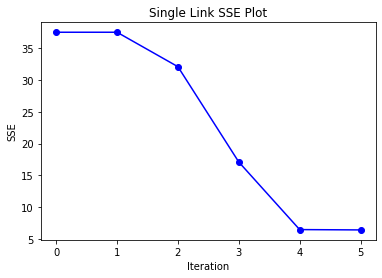

In [ ]:
# Clustering Labels using single-link
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

iris = arff.loadarff('iris.arff')
iris = pd.DataFrame(iris[0])
iris['class'] = iris['class'].str.decode('utf-8')

le = preprocessing.LabelEncoder()
le.fit(iris['class'])
iris['class'] = le.transform(iris['class'])

iris.head()
iris.iloc[:,:] = (iris.iloc[:,:] - iris.iloc[:,:].min()) / (iris.iloc[:,:].max() - iris.iloc[:,:].min())
iris = np.array(iris)

singleSSE = []
for i in range(2,8):
  hac_iris = HACClustering(k=i, link_type='single')
  hac_iris.fit(iris)
  print("Clusters: ", i)
  singleSSE.append(hac_iris.totalSSE)
  hac_iris.print_clusters()

plt.plot(singleSSE, color='blue', marker='o')
plt.ylabel('SSE')
plt.xlabel('Iteration')
plt.title("Single Link SSE Plot")
plt.show()

Clusters:  2
2
18.3937

[0.1961,0.5908,0.0786,0.06  ,0.    ]
50
1.8450

[0.545 ,0.3633,0.662 ,0.6567,0.75  ]
100
16.5487

Clusters:  3
3
10.8347

[0.7343,0.4708,0.8192,0.8611,1.    ]
30
1.4031

[0.4639,0.3173,0.5947,0.569 ,0.6429]
70
7.5866

[0.1961,0.5908,0.0786,0.06  ,0.    ]
50
1.8450

Clusters:  4
4
9.9327

[0.1062,0.4289,0.0708,0.0343,0.    ]
17
0.1991

[0.2424,0.6742,0.0827,0.0732,0.    ]
33
0.7438

[0.7343,0.4708,0.8192,0.8611,1.    ]
30
1.4031

[0.4639,0.3173,0.5947,0.569 ,0.6429]
70
7.5866

Clusters:  5
5
5.4397

[0.1062,0.4289,0.0708,0.0343,0.    ]
17
0.1991

[0.2424,0.6742,0.0827,0.0732,0.    ]
33
0.7438

[0.4875,0.3083,0.7   ,0.7146,1.    ]
20
0.6051

[0.7343,0.4708,0.8192,0.8611,1.    ]
30
1.4031

[0.4544,0.3208,0.5525,0.5108,0.5   ]
50
2.4885

Clusters:  6
6
4.3133

[0.578 ,0.4226,0.6045,0.5635,0.5   ]
21
0.3918

[0.1062,0.4289,0.0708,0.0343,0.    ]
17
0.1991

[0.2424,0.6742,0.0827,0.0732,0.    ]
33
0.7438

[0.3649,0.2471,0.5149,0.4727,0.5   ]
29
0.9703

[0.4875,0.3083,0.

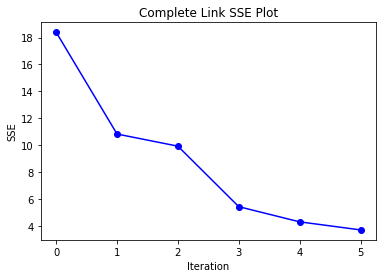

In [ ]:
# Clustering Labels using complete-link
completeSSE = []
for i in range(2,8):
  hac_iris = HACClustering(k=i, link_type='complete')
  hac_iris.fit(iris)
  print("Clusters: ", i)
  completeSSE.append(hac_iris.totalSSE)
  hac_iris.print_clusters()

plt.plot(completeSSE, color='blue', marker='o')
plt.ylabel('SSE')
plt.xlabel('Iteration')
plt.title("Complete Link SSE Plot")
plt.show()

Discuss any differences between the results from 2.1.1 and 2.1.2.

The results are pretty similar between the two datasets. It does look like the SSE is overall slightly lower when the model is classifying without the label. This is the case for both single and complete link.

## 2.2.1 (7.5%) Clustering the Iris Classification problem: K-Means

Load the Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

Run K-Means on the Iris dataset using the output label as a feature and without using the output label as a feature

Requirements:
- State whether you normalize your data or not (your choice).  
- Show your results for clusterings using k = 2-7.  
- Graph the total SSE for each k and discuss your results (i.e. what kind of clusters are being made).
---

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0   187k      0 --:--:-- --:--:-- --:--:--  187k
Initials [array([0.22222222, 0.625     , 0.06779661, 0.04166667]), array([0.16666667, 0.41666667, 0.06779661, 0.04166667])]
Clusters:  2
2
12.1437

[0.545 ,0.3633,0.662 ,0.6567]
100
10.2987

[0.1961,0.5908,0.0786,0.06  ]
50
1.8450

Initials [array([0.22222222, 0.625     , 0.06779661, 0.04166667]), array([0.16666667, 0.41666667, 0.06779661, 0.04166667]), array([0.11111111, 0.5       , 0.05084746, 0.04166667])]
Clusters:  3
3
6.9981

[0.7073,0.4509,0.797 ,0.8248]
39
2.0733

[0.4413,0.3074,0.5757,0.5492]
61
3.0798

[0.1961,0.5908,0.0786,0.06  ]
50
1.8450

Initials [array([0.22222222, 0.625     , 0.06779661, 0.04166667]), array([0.16666667, 0.41666667, 0.06779661, 0.04166667]), array([0.11111111, 0.5       , 0.05084746, 0.04166667]), array([0.08333333, 0.45

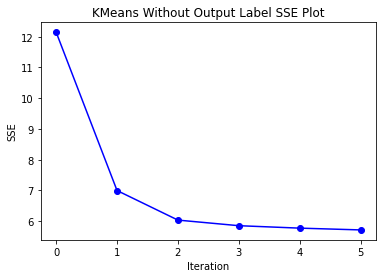

In [ ]:
# Iris Classification without output label
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

iris = arff.loadarff('iris.arff')
iris = pd.DataFrame(iris[0])
iris['class'] = iris['class'].str.decode('utf-8')

le = preprocessing.LabelEncoder()
le.fit(iris['class'])
iris['class'] = le.transform(iris['class'])

iris.head()
iris.iloc[:,:] = (iris.iloc[:,:] - iris.iloc[:,:].min()) / (iris.iloc[:,:].max() - iris.iloc[:,:].min())
iris = np.array(iris)
iris_data = iris[:,:-1]

singleSSE = []
for i in range(2,8):
  kmeans_iris = KMEANSClustering(k=i, debug=True)
  kmeans_iris.fit(iris_data)
  print("Clusters: ", i)
  singleSSE.append(kmeans_iris.totalSSE)
  kmeans_iris.print_clusters()

plt.plot(singleSSE, color='blue', marker='o')
plt.ylabel('SSE')
plt.xlabel('Iteration')
plt.title("KMeans Without Output Label SSE Plot")
plt.show()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0   166k      0 --:--:-- --:--:-- --:--:--  166k
Initials [array([0.22222222, 0.625     , 0.06779661, 0.04166667, 0.        ]), array([0.16666667, 0.41666667, 0.06779661, 0.04166667, 0.        ])]
Clusters:  2
2
18.3937

[0.1961,0.5908,0.0786,0.06  ,0.    ]
50
1.8450

[0.545 ,0.3633,0.662 ,0.6567,0.75  ]
100
16.5487

Initials [array([0.22222222, 0.625     , 0.06779661, 0.04166667, 0.        ]), array([0.16666667, 0.41666667, 0.06779661, 0.04166667, 0.        ]), array([0.11111111, 0.5       , 0.05084746, 0.04166667, 0.        ])]
Clusters:  3
3
7.8175

[0.4544,0.3208,0.5525,0.5108,0.5   ]
50
2.4885

[0.6356,0.4058,0.7715,0.8025,1.    ]
50
3.4840

[0.1961,0.5908,0.0786,0.06  ,0.    ]
50
1.8450

Initials [array([0.22222222, 0.625     , 0.06779661, 0.04166667, 0.        ]), array([0.16666667, 0.41666667,

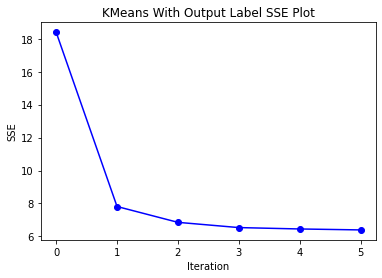

In [ ]:
# Iris Classification with output label
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

iris = arff.loadarff('iris.arff')
iris = pd.DataFrame(iris[0])
iris['class'] = iris['class'].str.decode('utf-8')

le = preprocessing.LabelEncoder()
le.fit(iris['class'])
iris['class'] = le.transform(iris['class'])

iris.head()
iris.iloc[:,:] = (iris.iloc[:,:] - iris.iloc[:,:].min()) / (iris.iloc[:,:].max() - iris.iloc[:,:].min())
iris = np.array(iris)

singleSSE = []
for i in range(2,8):
  kmeans_iris = KMEANSClustering(k=i, debug=True)
  kmeans_iris.fit(iris)
  print("Clusters: ", i)
  singleSSE.append(kmeans_iris.totalSSE)
  kmeans_iris.print_clusters()

plt.plot(singleSSE, color='blue', marker='o')
plt.ylabel('SSE')
plt.xlabel('Iteration')
plt.title("KMeans With Output Label SSE Plot")
plt.show()

I chose to normalize the data.
The SSE on both of the model, with abd without output labels, are very similar. However, the model that excludes the output label generally has a lower SSE.

## 2.2.2 (5%) Clustering the Iris Classification problem: K-Means

Requirements:
- Use the output label as an input feature
- Run K-Means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results. 

In [ ]:
#K-Means 5 times
!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

iris = arff.loadarff('iris.arff')
iris = pd.DataFrame(iris[0])
iris['class'] = iris['class'].str.decode('utf-8')

le = preprocessing.LabelEncoder()
le.fit(iris['class'])
iris['class'] = le.transform(iris['class'])

iris.head()
iris.iloc[:,:] = (iris.iloc[:,:] - iris.iloc[:,:].min()) / (iris.iloc[:,:].max() - iris.iloc[:,:].min())
iris = np.array(iris)

for i in range(5):
  kmeans_iris = KMEANSClustering(k=4, debug=False)
  kmeans_iris.fit(iris)
  print("Model #: ", i + 1)
  kmeans_iris.print_clusters()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  26263      0 --:--:-- --:--:-- --:--:-- 26263
Initials [array([0.61111111, 0.33333333, 0.61016949, 0.58333333, 0.5       ]), array([0.30555556, 0.58333333, 0.11864407, 0.04166667, 0.        ]), array([0.33333333, 0.91666667, 0.06779661, 0.04166667, 0.        ]), array([0.22222222, 0.20833333, 0.33898305, 0.41666667, 0.5       ])]
Model #:  1
4
6.8880

[0.6356,0.4058,0.7715,0.8025,1.    ]
50
3.4840

[0.1559,0.5162,0.0758,0.0544,0.    ]
36
0.6972

[0.2996,0.7827,0.086 ,0.0744,0.    ]
14
0.2183

[0.4544,0.3208,0.5525,0.5108,0.5   ]
50
2.4885

Initials [array([0.36111111, 0.20833333, 0.49152542, 0.41666667, 0.5       ]), array([0.55555556, 0.54166667, 0.62711864, 0.625     , 0.5       ]), array([0.05555556, 0.125     , 0.05084746, 0.08333333, 0.        ]), array([0.19444444, 0.54166667, 0.06779661, 0.0

5 models with 4 centroids produced some varied results. 
The total SSE's are: 6.8880, 6.8565, 6.3006, 6.6241, and 6.6333. All slightly different, but nothing was extreme.
Simlilarly, the 2nd cluster in every model had the highest SSE and the 3rd cluster had the lowest SSE

## 3.1 (12.5%) Run the SK versions of HAC (both single and complete link) on iris including the output label and compare your results with those above.
Use the silhouette score for this iris problem(k = 2-7).  You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function from [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) and compare the results. State which metric was used. 
- Possible sklean metrics include (* metrics require ground truth labels):
    - adjusted_mutual_info_score*
    - adjusted_rand_score*
    - homogeneity_score*
    - completeness_score*
    - fowlkes_mallows_score*
    - calinski_harabasz_score
    - davies_bouldin_score
- Experiment using different hyper-parameters. Discuss Results

In [ ]:
# Load sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.cluster import completeness_score

!curl https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff --output iris.arff

iris = arff.loadarff('iris.arff')
iris = pd.DataFrame(iris[0])
iris['class'] = iris['class'].str.decode('utf-8')

le = preprocessing.LabelEncoder()
le.fit(iris['class'])
iris['class'] = le.transform(iris['class'])

iris = np.array(iris)
targets = iris[:,-1]

for i in range(2,8):
  hac_clustering = AgglomerativeClustering(n_clusters=i, linkage='single')
  cluster_labels = hac_clustering.fit_predict(iris)
  complete_score = completeness_score(targets, cluster_labels)
  silhouette_avg = silhouette_score(iris, cluster_labels)
  print("For n_clusters =", i,
        "The average silhouette_score is :", silhouette_avg)
  print("For n_clusters =", i,
        "The completeness_score is :", complete_score)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  39603      0 --:--:-- --:--:-- --:--:-- 39603
For n_clusters = 2 The average silhouette_score is : 0.6822257796144715
For n_clusters = 2 The completeness_score is : 0.9999999999999997
For n_clusters = 3 The average silhouette_score is : 0.5780114722111267
For n_clusters = 3 The completeness_score is : 1.0
For n_clusters = 4 The average silhouette_score is : 0.5199399545522698
For n_clusters = 4 The completeness_score is : 0.9711129358060946
For n_clusters = 5 The average silhouette_score is : 0.4724098009577553
For n_clusters = 5 The completeness_score is : 0.9255381277335419
For n_clusters = 6 The average silhouette_score is : 0.4468980266143842
For n_clusters = 6 The completeness_score is : 0.8583434664464242
For n_clusters = 7 The average silhouette_score is : 0.39210972643122605
For n_clusters 

For the silhouette score, the number drops as the number of clusters increase. Silhuoette score seemed to work fairly well at selecting what clustering is best. 
For the completeness score, the best score occurs when number of clusters equals 3 because the iris dataset does really have 3 output classes. 
I tried using Manhattan distance instead of Euclidean distance, and the silhouette scores as well as the completeness scores were worse.

## 3.2 (12.5%) Run the SK version of k-means on iris including the output label and compare your results with those above. 

Use the silhouette score for this iris problem(k = 2-7). You may write your own code to do silhouette (optional extra credit) or you can use sklearn.metrics.silhouette_score. Please state if you coded your own silhouette score function to receive the extra credit points (described below). Discuss how helpful Silhouette appeared to be for selecting which clustering is best. You do not need to supply full Silhouette graphs, but you could if you wanted to.

Requirements
- Use the Sillhouette score for this iris problem (k= 2-7) 
- Use at least one other scoring function form sklearn.metrics and compare the results. State which metric was used
- Experiment different hyper-parameters. Discuss Results

In [ ]:
# Load sklearn 
from sklearn.cluster import KMeans

for i in range(2,8):
  kmeans_clustering = KMeans(n_clusters=i)
  cluster_labels = kmeans_clustering.fit_predict(iris)
  complete_score = completeness_score(targets, cluster_labels)
  silhouette_avg = silhouette_score(iris, cluster_labels)
  print("For n_clusters =", i,
        "The average silhouette_score is :", silhouette_avg)
  print("For n_clusters =", i,
        "The completeness_score is :", complete_score)


For n_clusters = 2 The average silhouette_score is : 0.6798027978812322
For n_clusters = 2 The completeness_score is : 0.9490204434010505
For n_clusters = 3 The average silhouette_score is : 0.5816937070990904
For n_clusters = 3 The completeness_score is : 0.9702500402649006
For n_clusters = 4 The average silhouette_score is : 0.5384620014392415
For n_clusters = 4 The completeness_score is : 0.7988108418133915
For n_clusters = 5 The average silhouette_score is : 0.5139872287357489
For n_clusters = 5 The completeness_score is : 0.6999730293338033
For n_clusters = 6 The average silhouette_score is : 0.5146383355996653
For n_clusters = 6 The completeness_score is : 0.6527589975262491
For n_clusters = 7 The average silhouette_score is : 0.3931238535124235
For n_clusters = 7 The completeness_score is : 0.5774287930339788


Based on the 2 metrics that I used for HAC and KMeans, HAC was a better model for the iris dataset. KMeans recieved lower scores on completeness and silhuoette through all number of clusters.
The silhuoette score appears to be pretty good at selecting which clustering is best; the values are positive but not super close to 1.
I tried changing a few hyper-parameters for the model such as random_state, max_iter, and n_init, but none of them changed the metric results that I was getting.

## 4. (Optional 5% extra credit) For your silhouette experiment above, write and use your own code to calculate the silhouette scores, rather than the SK or other version. 


*Show findings here*

In [ ]:
# Copy function Below